In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sympy as sp
import numpy as np

# Load directory ../Packages/PySW/ to path
import sys
sys.path.append('../Packages/PySW/')

In [3]:
from Modules.sympy.classes import *
from Modules.sympy.utils import *
from Modules.sympy.untruncated.solver import *

In [4]:
import matplotlib.pyplot as plt

# Latex Plot Beautification
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=16)    # fontsize of the tick labels
plt.rc('ytick', labelsize=16)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize

# Transparent background for figures but keep the legend background white but its text color black
plt.rcParams['legend.facecolor'] = 'white'
plt.rcParams['legend.edgecolor'] = 'none'
plt.rcParams['legend.framealpha'] = 0.8
plt.rcParams['legend.shadow'] = False
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['axes.facecolor'] = 'none'
# White spins, axis and ticks 
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
plt.rcParams['axes.labelcolor'] = 'white'
plt.rcParams['axes.edgecolor'] = 'white'


# Rabi Spin Model

In [5]:
dim_spin = 2

Spin = RDBasis("\\sigma", 'spin', dim = dim_spin)
s0, sx, sy, sz = Spin._basis


hbar = sp.Symbol("hbar", positive = True, real = True)
Omega_z = sp.Symbol("\\Omega_{z}", positive = True, real = True)
omega = sp.Symbol("omega", positive = True, real = True)
E0 = sp.Symbol("E_{0}", positive = True, real = True)
t = sp.Symbol("t", real = True, positive = True)

list_subspaces = [[Spin.subspace, Spin.dim]]

H = hbar * Omega_z * sp.Rational(1,2) * sz.matrix + hbar * E0 * sp.cos(omega * t) * sp.Rational(1,2) * sx.matrix
H

Matrix([
[        \Omega_{z}*hbar/2, E_{0}*hbar*cos(omega*t)/2],
[E_{0}*hbar*cos(omega*t)/2,        -\Omega_{z}*hbar/2]])

In [6]:
from scipy.linalg import expm

hbar_val = 1

def U_step_Apply(k, dt, H, to_be_applied):
    Ht = H((k-1) * dt)
    U = expm(-1j / hbar_val * Ht * dt)
    to_be_applied = U @ to_be_applied
    return to_be_applied


In [7]:
hbar = 1
Omega_z = 10
omega = 10
E0 = 1


detuning = np.abs(Omega_z - omega)
rabi_freq = np.sqrt(E0**2 + detuning**2)
rabi_period = 2*np.pi/rabi_freq

t1 = rabi_period

print(f"Rabi Frequency: {rabi_freq}")
print(f"Rabi Period: {rabi_period}")

N_steps = 1000
dt = t1/ N_steps

def H(t):
    return hbar * Omega_z / 2 * np.array(sz.matrix, complex) + hbar * E0 * (np.cos(omega * t)  * np.array(sx.matrix, complex))

Rabi Frequency: 1.0
Rabi Period: 6.283185307179586


In [8]:
init_state = np.array([1, 0])
observables = [sx.matrix, sy.matrix, sz.matrix]
observables = [np.array(observable, complex) for observable in observables]
projectors = [1/2 * (np.eye(2) + np.array(sz.matrix, complex)), 1/2 * (np.eye(2) - np.array(sz.matrix, complex))]
probabilities = [np.zeros(N_steps) for _ in projectors]

exp_vals = [np.zeros(N_steps) for _ in observables]

for k in range(N_steps):
    init_state = U_step_Apply(k, dt, H, init_state)

    for o, observable in enumerate(observables):
        exp_vals[o][k] = np.real(np.dot(init_state.conj(), observable @ init_state))
    
    for p, projector in enumerate(projectors):
        probabilities[p][k] = np.real(np.dot(init_state.conj(), projector @ init_state))

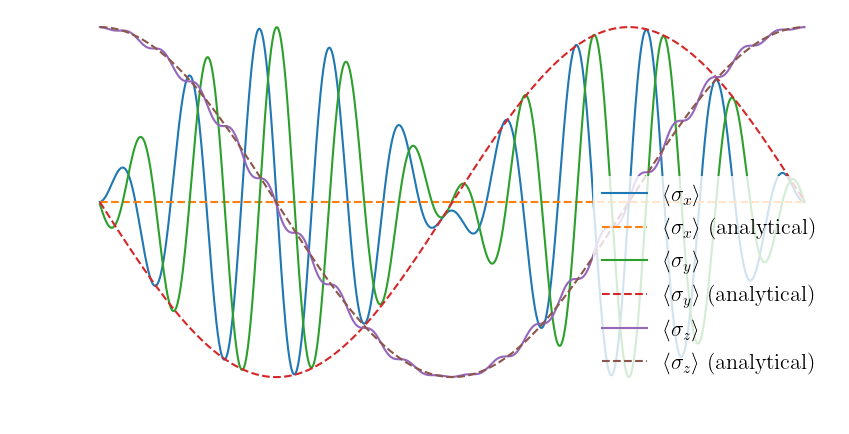

In [9]:
b_t = lambda t: np.array([
    E0 * detuning / rabi_freq**2 * (1 - np.cos(rabi_freq * t)),
    - E0 * np.sin(t * rabi_freq) / rabi_freq,
    (E0**2 * np.cos(t * rabi_freq) + detuning**2 )/ rabi_freq**2])


fig, ax = plt.subplots(1, 1, figsize=(10, 5))
obs_labels = [r"$\langle \sigma_x \rangle$", r"$\langle \sigma_y \rangle$", r"$\langle \sigma_z \rangle$", r"$P_0$", r"$P_1$"]

b_t_vals = b_t(np.arange(N_steps) * dt)
for o, observable in enumerate(observables):
    ax.plot(np.arange(N_steps) * dt, exp_vals[o], label = obs_labels[o])
    ax.plot(np.arange(N_steps) * dt, b_t_vals[o], label = obs_labels[o] + " (analytical)", linestyle = "--")


ax.legend()

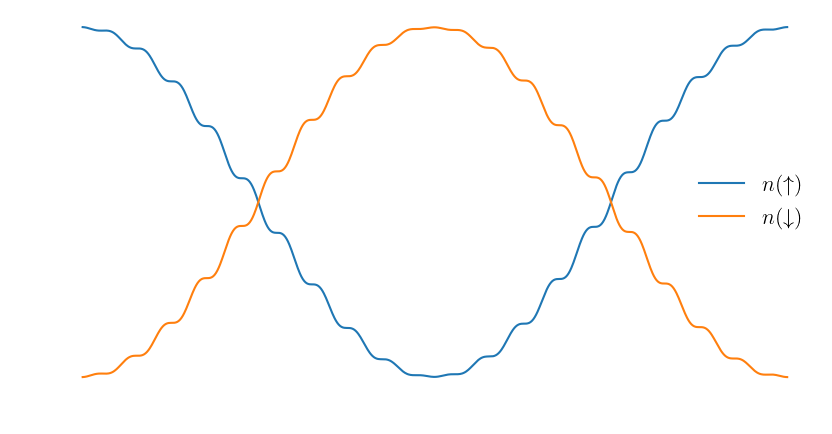

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
probs_labels = [r"$n(\uparrow)$", r"$n(\downarrow)$"]
for p, projector in enumerate(projectors):
    ax.plot(np.arange(N_steps) * dt, probabilities[p], label = probs_labels[p])

ax.legend()

# Rabi Model with Bosonic Operators

In [127]:
dim_spin = 2

Spin = RDBasis("\\sigma", 'spin', dim = dim_spin)
s0, sx, sy, sz = Spin._basis

a = RDBoson("a", subspace ="confinement")
ad = RDBoson("{a^\\dagger}", subspace ="confinement", is_annihilation=False)

commutation_relations = {
    a*ad: ad * a + 1,
}

hbar = RDsymbol("hbar", order = 0)
omega_x = RDsymbol("omega_x", order = 0)
Omega_z = RDsymbol("\\Omega_{z}", order = 0)
g = RDsymbol("g", order = 1) # g = b_sl /2 * sqrt(hbar / 2 m omega_x)

H = hbar * omega_x * ad * a - hbar * Omega_z * sp.Rational(1,2) * sz + hbar * g * (a + ad) * sx
H

-\Omega_{z}*hbar*\sigma_{3}/2 + g*hbar*(a + {a^\dagger})*\sigma_{1} + hbar*omega_x*{a^\dagger}*a

In [130]:
sol = solver(H, Spin, order=4, full_diagonal=True, commutation_relations=commutation_relations)
sol[0]

 37%|███▋      | 11/30 [00:02<00:05,  3.76it/s]/mnt/c/Users/reasc/OneDrive - Universität Augsburg/PhD_Brain/Python Notebooks/Qubit Hamiltonians/../Packages/PySW/Modules/sympy/untruncated/solver.py:402: UserWarning: 
Inconsistency in equations to solve. The equations used to solve for S are not linearly independent.
Full diagonalization up to the selected order for the given problem is not yet supported. We
recommend to either lower perturbation order, or otherwise use the truncated solver.
  warnings.warn('\n' + warnig_message)
/mnt/c/Users/reasc/OneDrive - Universität Augsburg/PhD_Brain/Python Notebooks/Qubit Hamiltonians/../Packages/PySW/Modules/sympy/untruncated/solver.py:322: UserWarning: Solution not found for key {a^\dagger}*a**2.
  warnings.warn(f"Solution not found for key {key}.")
100%|██████████| 30/30 [00:15<00:00,  1.98it/s]


36*\Omega_{z}**9*g**4*hbar*{a^\dagger}*a*\sigma_{3}/(3*\Omega_{z}**12 - 42*\Omega_{z}**10*omega_x**2 + 165*\Omega_{z}**8*omega_x**4 - 300*\Omega_{z}**6*omega_x**6 + 285*\Omega_{z}**4*omega_x**8 - 138*\Omega_{z}**2*omega_x**10 + 27*omega_x**12) + 18*\Omega_{z}**9*g**4*hbar*{a^\dagger}**2*a**2*\sigma_{3}/(3*\Omega_{z}**12 - 42*\Omega_{z}**10*omega_x**2 + 165*\Omega_{z}**8*omega_x**4 - 300*\Omega_{z}**6*omega_x**6 + 285*\Omega_{z}**4*omega_x**8 - 138*\Omega_{z}**2*omega_x**10 + 27*omega_x**12) + 9*\Omega_{z}**9*g**4*hbar*\sigma_{3}/(3*\Omega_{z}**12 - 42*\Omega_{z}**10*omega_x**2 + 165*\Omega_{z}**8*omega_x**4 - 300*\Omega_{z}**6*omega_x**6 + 285*\Omega_{z}**4*omega_x**8 - 138*\Omega_{z}**2*omega_x**10 + 27*omega_x**12) - 16*\Omega_{z}**8*g**4*hbar*omega_x/(3*\Omega_{z}**12 - 42*\Omega_{z}**10*omega_x**2 + 165*\Omega_{z}**8*omega_x**4 - 300*\Omega_{z}**6*omega_x**6 + 285*\Omega_{z}**4*omega_x**8 - 138*\Omega_{z}**2*omega_x**10 + 27*omega_x**12) - 32*\Omega_{z}**8*g**4*hbar*omega_x*{a^\dag

In [133]:
E = RDsymbol("\\tilde{E}", order = 0) # E = e E_0 * sqrt(hbar/ 2 m omega_x)
H_driving = E * (a + ad)
H_driving_ = sp.Add(*rotate_with_S(H_driving, sol[1], order=2, composite_basis=Spin, commutation_relations=commutation_relations).values())
display_dict(group_by_list_operators(H_driving_, [a, ad, sx, sy, sz]))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [134]:
bsl = 30
m = 1
Omega_z_val = 10
omega_x_val = 20
g_val = bsl / 2 * np.sqrt(1 / (2 * m * omega_x_val))
E_val = 0.3

omega_qubit = 2 * (sol[0] + H_driving_).subs({a:0, ad:0}).coeff(sz)
E_0_val = (sol[0] + H_driving_).subs({a:0, ad:0}).coeff(sx)

subs_vals = {
    hbar : 1,
    Omega_z: Omega_z_val,
    omega_x: omega_x_val,
    g: g_val,
}

omega_qubit = np.abs(omega_qubit.subs(subs_vals))
omega_D = 9#omega_qubit
detuning = float(np.abs(omega_qubit - omega_D))
E_0_val = float(E_0_val.subs(subs_vals).subs({E: E_val}))
rabi_freq = np.sqrt(E_0_val**2 + detuning**2)

subs_vals[E] = E_val * sp.cos(omega_D * t)

print(f"Detuning: {detuning}")
print(f"Rabi Frequency: {rabi_freq}")

tr = 2 * np.pi / rabi_freq
print(f"Rabi Period: {tr}")
N_steps = 1000
dt = tr / N_steps

display_dict(subs_vals)

ops = [sx, sz]
H_final = (sol[0] + H_driving_).subs({a:0, ad:0})

display(H_final)

def H_rabi(t_val):
    H_res = H_final.subs(subs_vals).subs(subs_vals).subs({t:t_val})
    H_res = get_matrix(H_res, [[Spin.subspace, Spin.dim]])
    return np.array(H_res, complex)

H_rabi(0)

Detuning: 0.6460937499999986
Rabi Frequency: 0.6530215415964933
Rabi Period: 9.621712159477292


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

9*\Omega_{z}**9*g**4*hbar*\sigma_{3}/(3*\Omega_{z}**12 - 42*\Omega_{z}**10*omega_x**2 + 165*\Omega_{z}**8*omega_x**4 - 300*\Omega_{z}**6*omega_x**6 + 285*\Omega_{z}**4*omega_x**8 - 138*\Omega_{z}**2*omega_x**10 + 27*omega_x**12) - 16*\Omega_{z}**8*g**4*hbar*omega_x/(3*\Omega_{z}**12 - 42*\Omega_{z}**10*omega_x**2 + 165*\Omega_{z}**8*omega_x**4 - 300*\Omega_{z}**6*omega_x**6 + 285*\Omega_{z}**4*omega_x**8 - 138*\Omega_{z}**2*omega_x**10 + 27*omega_x**12) - 92*\Omega_{z}**7*g**4*hbar*omega_x**2*\sigma_{3}/(3*\Omega_{z}**12 - 42*\Omega_{z}**10*omega_x**2 + 165*\Omega_{z}**8*omega_x**4 - 300*\Omega_{z}**6*omega_x**6 + 285*\Omega_{z}**4*omega_x**8 - 138*\Omega_{z}**2*omega_x**10 + 27*omega_x**12) + 176*\Omega_{z}**6*g**4*hbar*omega_x**3/(3*\Omega_{z}**12 - 42*\Omega_{z}**10*omega_x**2 + 165*\Omega_{z}**8*omega_x**4 - 300*\Omega_{z}**6*omega_x**6 + 285*\Omega_{z}**4*omega_x**8 - 138*\Omega_{z}**2*omega_x**10 + 27*omega_x**12) + 94*\Omega_{z}**5*g**4*hbar*omega_x**4*\sigma_{3}/(3*\Omega_{z}**

array([[-5.18867187+0.j, -0.09486833+0.j],
       [-0.09486833+0.j,  4.45742187+0.j]])

In [135]:
def U_step_Apply(k, dt, H, to_be_applied):
    Ht = H((k-1) * dt)
    U = expm(-1j / hbar_val * Ht * dt)
    to_be_applied = U @ to_be_applied
    return to_be_applied


In [136]:
init_state = np.array([1, 0])

projectors = [1/2 * (np.eye(2) + np.array(sz.matrix, complex)), 1/2 * (np.eye(2) - np.array(sz.matrix, complex))]
probabilities = [np.zeros(N_steps) for _ in projectors]


for k in range(N_steps):
    init_state = U_step_Apply(k, dt, H_rabi, init_state)
    
    for p, projector in enumerate(projectors):
        probabilities[p][k] = np.real(np.dot(init_state.conj(), projector @ init_state))

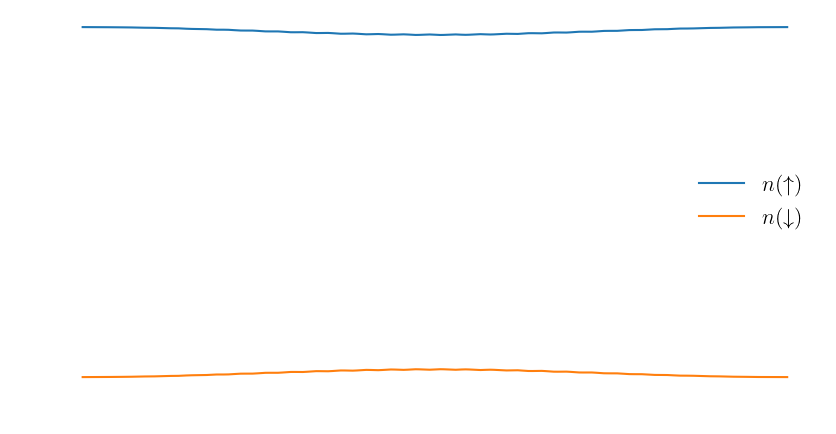

In [137]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
probs_labels = [r"$n(\uparrow)$", r"$n(\downarrow)$"]
for p, projector in enumerate(projectors):
    ax.plot(np.arange(N_steps) * dt, probabilities[p], label = probs_labels[p])

ax.legend()

In [138]:
dim_spin = 2
dim_boson = 5

Spin = RDBasis("\\sigma", 'spin', dim = dim_spin)
s0, sx, sy, sz = Spin._basis

a = RDBoson("a", subspace ="confinement", dim_projection=dim_boson)
ad = RDBoson("{a^\\dagger}", subspace ="confinement", is_annihilation=False, dim_projection=dim_boson)

commutation_relations = {
    a*ad: ad * a + 1,
}

subspaces = [[Spin.subspace, Spin.dim], [a.subspace, dim_boson]]

hbar = RDsymbol("hbar", order = 0)
omega_x = RDsymbol("omega_x", order = 0)
Omega_z = RDsymbol("\\Omega_{z}", order = 0)
g = RDsymbol("g", order = 1) # g = b_sl /2 * sqrt(hbar / 2 m omega_x)

H = hbar * omega_x * ad * a - hbar * Omega_z * sp.Rational(1,2) * sz + hbar * g * (a + ad) * sx
H_mat = get_matrix(H + E * (a + ad), subspaces)
H_mat

Matrix([
[-\Omega_{z}*hbar/2,                         \tilde{E},                                   0,                                   0,                                   0,                 0,                           g*hbar,                                  0,                                  0,                                  0],
[         \tilde{E}, -\Omega_{z}*hbar/2 + hbar*omega_x,                   sqrt(2)*\tilde{E},                                   0,                                   0,            g*hbar,                                0,                     sqrt(2)*g*hbar,                                  0,                                  0],
[                 0,                 sqrt(2)*\tilde{E}, -\Omega_{z}*hbar/2 + 2*hbar*omega_x,                   sqrt(3)*\tilde{E},                                   0,                 0,                   sqrt(2)*g*hbar,                                  0,                     sqrt(3)*g*hbar,                                  0],
[   

In [139]:
def H_total(t_val):
    return np.array(sp.N(H_mat.subs(subs_vals)).subs({t:t_val}), complex)

H_0_mat = np.array(get_matrix(H, subspaces).subs(subs_vals), complex)

states = np.linalg.eig(H_0_mat)
energies = states[0]
order = np.argsort(energies)
states = [states[0][order], states[1][:,order]]
ground_state = states[1][:,0]

In [140]:
init_state = ground_state

projectors = [s.reshape(-1, 1).dot(s.reshape(-1, 1).T.conj()) for s in states[1].T]
probabilities = np.zeros((dim_spin * dim_boson, N_steps), float)

for k in range(N_steps):
    init_state = U_step_Apply(k, dt, H_total, init_state)
    probabilities[:, k] = np.real(init_state.conj().T @ projectors @ init_state)

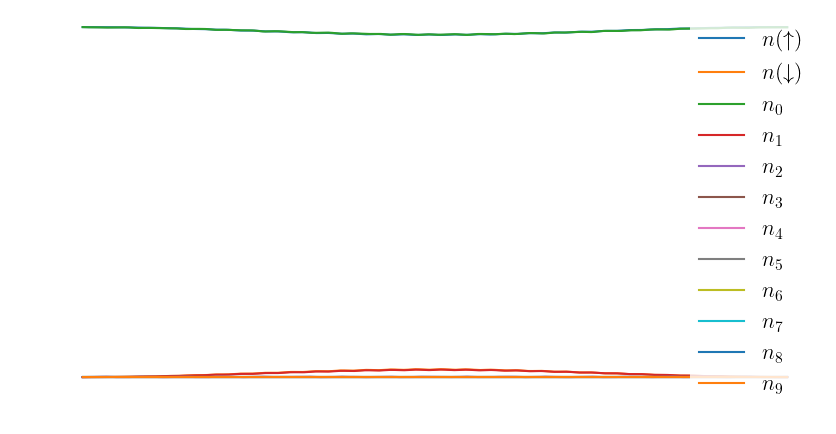

In [141]:
for p in range(dim_spin * dim_boson):
    ax.plot(np.arange(N_steps) * dt, probabilities[p], label = r'$n_{%d}$' % p)

ax.legend()
fig